# Fitting with flat production and constant sampling

Sometimes you want to fit a simpler model, with a dead flat production for a long time. If you're using the default adaptive step size solver, this will break, sending the step size to some very large value and skipping most of the event! This tutorial shows how you can turn off the sinusoidal production *and* the adaptive step size solver.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ticktack
from ticktack import fitting

from tqdm import tqdm
from matplotlib.lines import Line2D

Now, we load a presaved model; `ticktack` currently has pre-saved reimplementations of the carbon box models from
['Guttler15'](https://www.sciencedirect.com/science/article/pii/S0012821X14007481?via%3Dihub#fg0030), ['Brehm21'](https://www.nature.com/articles/s41561-020-00674-0), ['Miyake17'](https://ui.adsabs.harvard.edu/abs/2017PNAS..114..881M/abstract), or ['Buntgen18'](https://www.nature.com/articles/s41467-018-06036-0#Sec12). 

In [2]:
cbm = ticktack.load_presaved_model("Guttler15", production_rate_units = "atoms/cm^2/s")

Now we initialize a `SingleFitter` object using this carbon box model, together with the data from Miyake et al, 2012. This will handle Bayesian inference of production rates conditioned on these data.

In [3]:
sf = fitting.SingleFitter(cbm, cbm_model="Guttler15",adaptive=False)
sf.load_data("miyake12.csv")
sf.compile_production_model(model="spike_only")

The default engine for sampling from this posterior is [emcee](https://emcee.readthedocs.io/en/stable/). We are working on implementing nested sampling and variational inference. We call `emcee` from a method of the `SingleFitter` object like this, where params are (arrival time in years, duration in years, solar cycle phase in years, and total radiocarbon delivered in production rate times years).

In [4]:
%%time
default_params = np.array([775., np.log10(1./12),  np.log10(81./12)])
sampler = sf.MarkovChainSampler(default_params, 
                                likelihood = sf.log_joint_likelihood, 
                                burnin = 1000, 
                                production = 2000, 
                                args = (np.array([770., np.log10(1/52.),  -2]), # lower bound
                                np.array([780., np.log10(5.),  1.5]))         # upper bound 
                               )
samples = sampler.copy()
samples[:,1:] = 10**samples[:,1:]


Running burn-in...


100%|██████████| 1000/1000 [00:08<00:00, 111.82it/s]


Running production...


100%|██████████| 2000/2000 [00:17<00:00, 116.55it/s]

CPU times: user 25.7 s, sys: 4.98 s, total: 30.7 s
Wall time: 26.9 s


Plot of posterior surface using [ChainConsumer](https://samreay.github.io/ChainConsumer/):

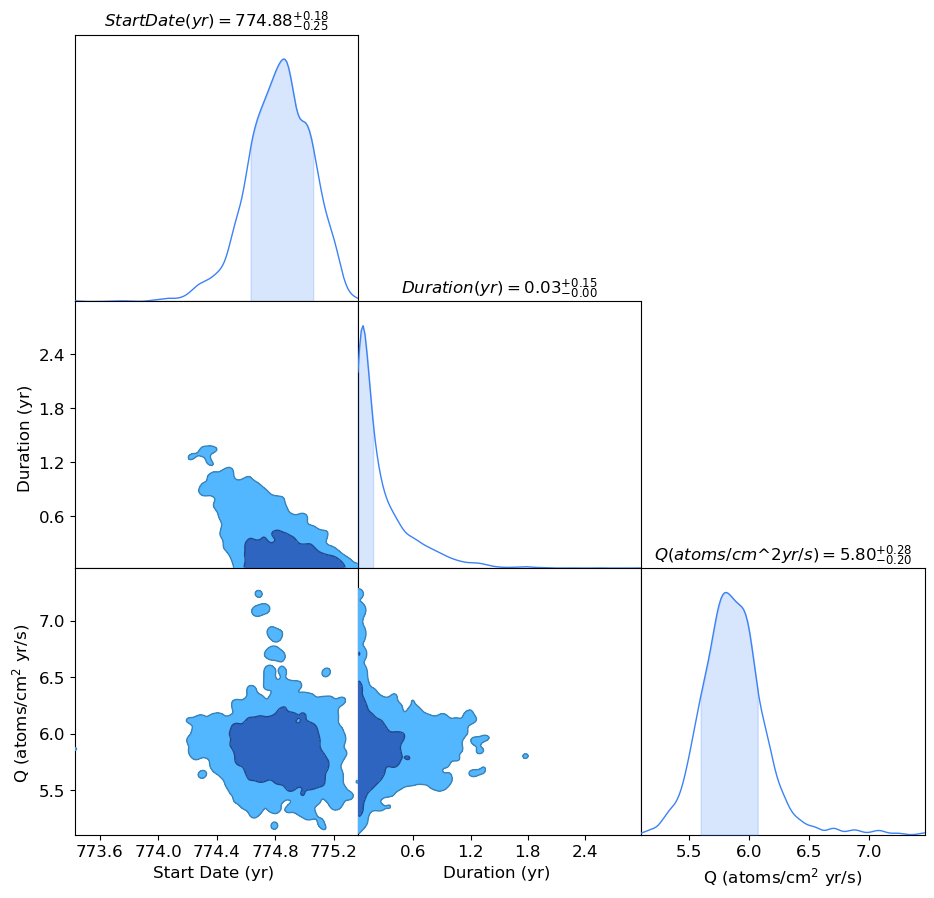

In [5]:
labels = ["Start Date (yr)", "Duration (yr)", "Q (atoms/cm$^2$ yr/s)"]
fig = sf.chain_summary(samples, 8, labels=labels, label_font_size=12, tick_font_size=12)

And a plot of models evaluated from samples of the posterior parameters shows a pretty good fit!

100%|██████████| 30/30 [00:00<00:00, 269.94it/s]


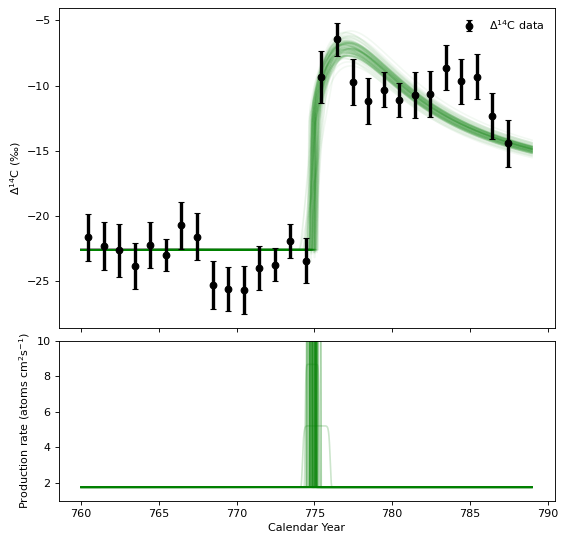

In [6]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]}, dpi=80)
fig.subplots_adjust(hspace=0.05)
plt.rcParams.update({"text.usetex": False})
idx = np.random.randint(len(sampler), size=100)
for param in tqdm(sampler[idx]):
    ax1.plot(sf.time_data_fine, sf.dc14_fine(params=param), alpha=0.05, color="g")

for param in tqdm(sampler[idx][:30]):
    ax2.plot(sf.time_data_fine, sf.production(sf.time_data_fine, *param), alpha=0.2, color="g")

ax1.errorbar(sf.time_data + sf.time_offset, sf.d14c_data, yerr=sf.d14c_data_error, 
             fmt="ok", capsize=3, markersize=6, elinewidth=3, label="$\Delta^{14}$C data")
ax1.legend(frameon=False);
ax2.set_ylim(1, 10);
ax1.set_ylabel("$\Delta^{14}$C (‰)")
ax2.set_xlabel("Calendar Year");
ax2.set_ylabel("Production rate (atoms cm$^2$s$^{-1}$)");